In [59]:
import pandas as pd
import pydicom
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
from pathlib import Path
import shutil
import sys
from pathlib import Path
import os
from PIL import Image

In [2]:
cwd = Path.cwd()
while cwd.stem != "pyplatypus":
    cwd = cwd.parent
os.chdir(cwd)

# Prepare dataset

In [3]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [62]:
def prepare_train_val_data(
        raw_data_paths: list[Path],
        csv_path: Path,
        data_path: Path,
        val_train_ratio: float=0.2
):
    training_data_path = data_path + "/siim_training"
    validation_data_path = data_path + "/siim_validation"
    
    Path(training_data_path).mkdir(parents=True, exist_ok=True)
    Path(validation_data_path).mkdir(parents=True, exist_ok=True)
    
    data_df = pd.read_csv(csv_path)
    width, height = 1024, 1024
    not_empty_masks = list()

    for idx, path in enumerate(raw_data_paths):
        file_name = path.split('/')[-1][:-4]
        if all(data_df["ImageId"] != file_name):
            continue
        data_path = validation_data_path if np.random.uniform() <= val_train_ratio else training_data_path
        Path(f"{data_path}/image_{idx}").mkdir(parents=True, exist_ok=True)
        rle_mask = data_df[data_df["ImageId"] == file_name][" EncodedPixels"].values[0]
        if  "-1" in rle_mask:
            mask = np.zeros((width, height))
        else:
            mask = rle2mask(rle_mask, width, height)
            not_empty_masks.append(idx)
        Path(f"{data_path}/image_{idx}/images").mkdir(parents=True, exist_ok=True)
        Path(f"{data_path}/image_{idx}/masks").mkdir(parents=True, exist_ok=True)
        shutil.copyfile(path, f"{data_path}/image_{idx}/images/image_{idx}.dcm")
        #matplotlib.image.imsave(f"{data_path}/image_{idx}/masks/mask_{idx}.png", mask)
        im = Image.fromarray(mask).convert('RGB')
        im.save(f"{data_path}/image_{idx}/masks/mask_{idx}.png")

In [63]:
raw_data_paths = sorted(glob('examples/data/sim-arc/dicom-images-train/*/*/*.dcm'))
data_path = "examples/data/sim-arc/"
csv_path = "examples/data/sim-arc/train-rle.csv"
prepare_train_val_data(raw_data_paths, csv_path, data_path)

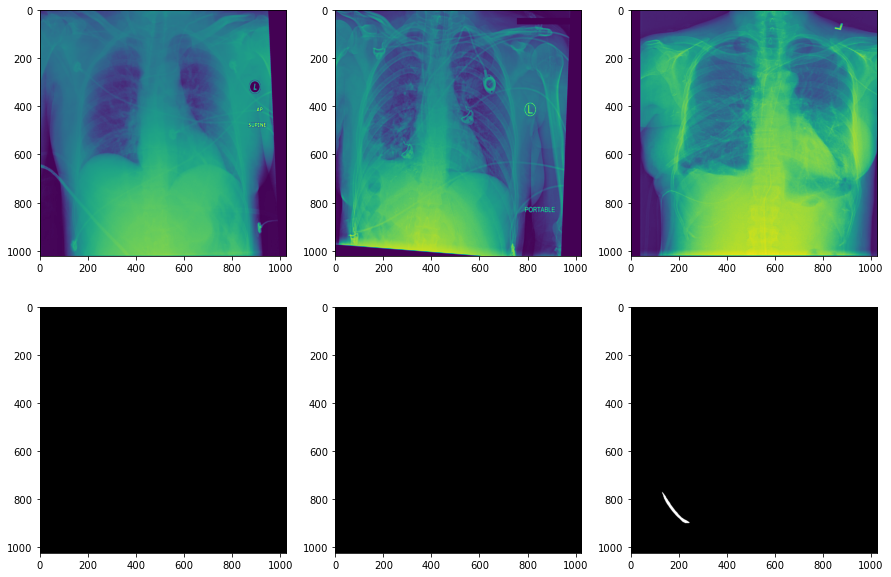

In [70]:
random_imgs_idxs = np.random.choice([i.split("_")[1] for i in os.listdir(data_path + "/siim_training")], 3)
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for idx, random_imgs_idx in enumerate(random_imgs_idxs):
    img_path = data_path + f"/siim_training/image_{random_imgs_idx}/images/image_{random_imgs_idx}.dcm"
    mask_path = data_path + f"/siim_training/image_{random_imgs_idx}/masks/mask_{random_imgs_idx}.png"
    img = pydicom.dcmread(img_path).pixel_array
    mask = plt.imread(mask_path)
    axs[0, idx].imshow(img)
    axs[1, idx].imshow(mask)

# Run training

In [77]:
from pyplatypus.solvers.platypus_cv_solver import PlatypusSolver

ps = PlatypusSolver(
    config_yaml_path=Path("examples/siim_acr.yml")
)
ps.train()

10277 images detected!
Set 'steps_per_epoch' to: 643
3961 images detected!
Set 'steps_per_epoch' to: 248
Training model:  sim_acr_res_u_net
Epoch 1/100
643/643 [==============================] - 1001s 2s/step - loss: 0.0460 - tversky_coefficient: 0.6490 - iou_coefficient: 0.6172 - categorical_crossentropy: 0.1742 - val_loss: 0.0039 - val_tversky_coefficient: 0.5100 - val_iou_coefficient: 0.5033 - val_categorical_crossentropy: 0.0292
Epoch 2/100
643/643 [==============================] - 1013s 2s/step - loss: 0.0060 - tversky_coefficient: 0.7838 - iou_coefficient: 0.7713 - categorical_crossentropy: 0.0379 - val_loss: 0.0038 - val_tversky_coefficient: 0.5190 - val_iou_coefficient: 0.5139 - val_categorical_crossentropy: 0.0222
Epoch 3/100
643/643 [==============================] - 916s 1s/step - loss: 0.0059 - tversky_coefficient: 0.7874 - iou_coefficient: 0.7757 - categorical_crossentropy: 0.0353 - val_loss: 0.0036 - val_tversky_coefficient: 0.5214 - val_iou_coefficient: 0.5169 - val_cat

643/643 [==============================] - 892s 1s/step - loss: 0.0056 - tversky_coefficient: 0.7919 - iou_coefficient: 0.7814 - categorical_crossentropy: 0.0316 - val_loss: 0.0034 - val_tversky_coefficient: 0.5196 - val_iou_coefficient: 0.5146 - val_categorical_crossentropy: 0.0212
Epoch 28/100
643/643 [==============================] - 905s 1s/step - loss: 0.0055 - tversky_coefficient: 0.7918 - iou_coefficient: 0.7813 - categorical_crossentropy: 0.0317 - val_loss: 0.0034 - val_tversky_coefficient: 0.5221 - val_iou_coefficient: 0.5176 - val_categorical_crossentropy: 0.0194
Epoch 29/100
643/643 [==============================] - 902s 1s/step - loss: 0.0056 - tversky_coefficient: 0.7919 - iou_coefficient: 0.7814 - categorical_crossentropy: 0.0316 - val_loss: 0.0034 - val_tversky_coefficient: 0.5203 - val_iou_coefficient: 0.5155 - val_categorical_crossentropy: 0.0207
Epoch 30/100
643/643 [==============================] - 894s 1s/step - loss: 0.0055 - tversky_coefficient: 0.7918 - iou_co

Epoch 55/100
643/643 [==============================] - 891s 1s/step - loss: 0.0053 - tversky_coefficient: 0.7930 - iou_coefficient: 0.7829 - categorical_crossentropy: 0.0306 - val_loss: 0.0032 - val_tversky_coefficient: 0.5232 - val_iou_coefficient: 0.5190 - val_categorical_crossentropy: 0.0183
Epoch 56/100
643/643 [==============================] - 896s 1s/step - loss: 0.0053 - tversky_coefficient: 0.7935 - iou_coefficient: 0.7834 - categorical_crossentropy: 0.0303 - val_loss: 0.0032 - val_tversky_coefficient: 0.5224 - val_iou_coefficient: 0.5180 - val_categorical_crossentropy: 0.0189
Epoch 57/100
643/643 [==============================] - 891s 1s/step - loss: 0.0053 - tversky_coefficient: 0.7936 - iou_coefficient: 0.7836 - categorical_crossentropy: 0.0301 - val_loss: 0.0031 - val_tversky_coefficient: 0.5220 - val_iou_coefficient: 0.5176 - val_categorical_crossentropy: 0.0191
Epoch 58/100
643/643 [==============================] - 889s 1s/step - loss: 0.0053 - tversky_coefficient: 0.

643/643 [==============================] - 942s 1s/step - loss: 0.0051 - tversky_coefficient: 0.7956 - iou_coefficient: 0.7862 - categorical_crossentropy: 0.0285 - val_loss: 0.0030 - val_tversky_coefficient: 0.5237 - val_iou_coefficient: 0.5196 - val_categorical_crossentropy: 0.0177
Epoch 83/100
643/643 [==============================] - 945s 1s/step - loss: 0.0051 - tversky_coefficient: 0.7953 - iou_coefficient: 0.7858 - categorical_crossentropy: 0.0287 - val_loss: 0.0030 - val_tversky_coefficient: 0.5251 - val_iou_coefficient: 0.5212 - val_categorical_crossentropy: 0.0167
Epoch 84/100
643/643 [==============================] - 948s 1s/step - loss: 0.0051 - tversky_coefficient: 0.7957 - iou_coefficient: 0.7862 - categorical_crossentropy: 0.0284 - val_loss: 0.0030 - val_tversky_coefficient: 0.5237 - val_iou_coefficient: 0.5196 - val_categorical_crossentropy: 0.0177
Epoch 85/100
643/643 [==============================] - 947s 1s/step - loss: 0.0051 - tversky_coefficient: 0.7956 - iou_co

Epoch 10/100
1285/1285 [==============================] - 834s 649ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0086 - val_categorical_crossentropy: 0.0086 - val_iou_coefficient: 0.5395
Epoch 11/100
1285/1285 [==============================] - 831s 647ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0087 - val_categorical_crossentropy: 0.0087 - val_iou_coefficient: 0.5395
Epoch 12/100
1285/1285 [==============================] - 830s 646ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0086 - val_categorical_crossentropy: 0.0086 - val_iou_coefficient: 0.5398
Epoch 13/100
1285/1285 [==============================] - 830s 646ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0086 - val_categorical_crossentropy: 0.0086 - val_iou_coefficient: 0.5397
Epoch 14/100
1285/1285 [========================

1285/1285 [==============================] - 828s 645ms/step - loss: 0.0135 - categorical_crossentropy: 0.0135 - iou_coefficient: 0.8221 - val_loss: 0.0085 - val_categorical_crossentropy: 0.0085 - val_iou_coefficient: 0.5396
Epoch 45/100
1285/1285 [==============================] - 827s 644ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0084 - val_categorical_crossentropy: 0.0084 - val_iou_coefficient: 0.5392
Epoch 46/100
1285/1285 [==============================] - 818s 636ms/step - loss: 0.0135 - categorical_crossentropy: 0.0135 - iou_coefficient: 0.8221 - val_loss: 0.0084 - val_categorical_crossentropy: 0.0084 - val_iou_coefficient: 0.5395
Epoch 47/100
1285/1285 [==============================] - 827s 644ms/step - loss: 0.0135 - categorical_crossentropy: 0.0135 - iou_coefficient: 0.8221 - val_loss: 0.0084 - val_categorical_crossentropy: 0.0084 - val_iou_coefficient: 0.5395
Epoch 48/100
1285/1285 [==============================] - 816

1285/1285 [==============================] - 892s 694ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0083 - val_categorical_crossentropy: 0.0083 - val_iou_coefficient: 0.5396
Epoch 79/100
1285/1285 [==============================] - 881s 685ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0084 - val_categorical_crossentropy: 0.0084 - val_iou_coefficient: 0.5395
Epoch 80/100
1285/1285 [==============================] - 888s 691ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0083 - val_categorical_crossentropy: 0.0083 - val_iou_coefficient: 0.5397
Epoch 81/100
1285/1285 [==============================] - 886s 689ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0083 - val_categorical_crossentropy: 0.0083 - val_iou_coefficient: 0.5393
Epoch 82/100
1285/1285 [==============================] - 879

Epoch 12/100
1285/1285 [==============================] - 959s 746ms/step - loss: 0.2009 - iou_coefficient: 0.7407 - categorical_crossentropy: 0.2009 - val_loss: 0.4727 - val_iou_coefficient: 0.4891 - val_categorical_crossentropy: 0.4727
Epoch 13/100
1285/1285 [==============================] - 941s 733ms/step - loss: 0.2860 - iou_coefficient: 0.7406 - categorical_crossentropy: 0.2860 - val_loss: 14.0258 - val_iou_coefficient: 0.4374 - val_categorical_crossentropy: 14.0258
Epoch 14/100
1285/1285 [==============================] - 1017s 791ms/step - loss: 0.3202 - iou_coefficient: 0.7379 - categorical_crossentropy: 0.3202 - val_loss: 14.4010 - val_iou_coefficient: 0.0091 - val_categorical_crossentropy: 14.4010
Epoch 15/100
1285/1285 [==============================] - 1009s 785ms/step - loss: 0.2799 - iou_coefficient: 0.7366 - categorical_crossentropy: 0.2799 - val_loss: 42.1565 - val_iou_coefficient: 0.0452 - val_categorical_crossentropy: 42.1565
Epoch 16/100
1285/1285 [================

In [78]:
metrics = ps.evaluate_models(task_type="semantic_segmentation")

3961 images detected!
Set 'steps_per_epoch' to: 248
248/248 [==============================] - 210s 848ms/step - loss: 0.0030 - tversky_coefficient: 0.5255 - iou_coefficient: 0.5218 - categorical_crossentropy: 0.0163
3961 images detected!
Set 'steps_per_epoch' to: 496
496/496 [==============================] - 202s 407ms/step - loss: 0.0083 - categorical_crossentropy: 0.0083 - iou_coefficient: 0.5396
3961 images detected!
Set 'steps_per_epoch' to: 496
496/496 [==============================] - 249s 502ms/step - loss: 0.0205 - iou_coefficient: 0.5409 - categorical_crossentropy: 0.0205
EVALUATION RESULTS:

                                    model_name  focal_loss  \
0                            sim_acr_res_u_net    0.002968   
0                      sim_acr_u_net_plus_plus         NaN   
0  sim_acr_res_u_net_u_net_plus_plus_ensembler         NaN   

   categorical_crossentropy  iou_coefficient  tversky_coefficient  cce_loss  
0                  0.525487         0.521756              0.0

In [10]:
# Ive chosen a subset of validation dataset for inference 
images_for_prediction_path = "examples/data/siim_validation_10"
ps.produce_and_save_predicted_masks_for_model(
    model_name="sim_acr_res_u_net",
    custom_data_path=images_for_prediction_path)

9 images detected!
Set 'steps_per_epoch' to: 1
1/1 [==============================] - 1s 740ms/step


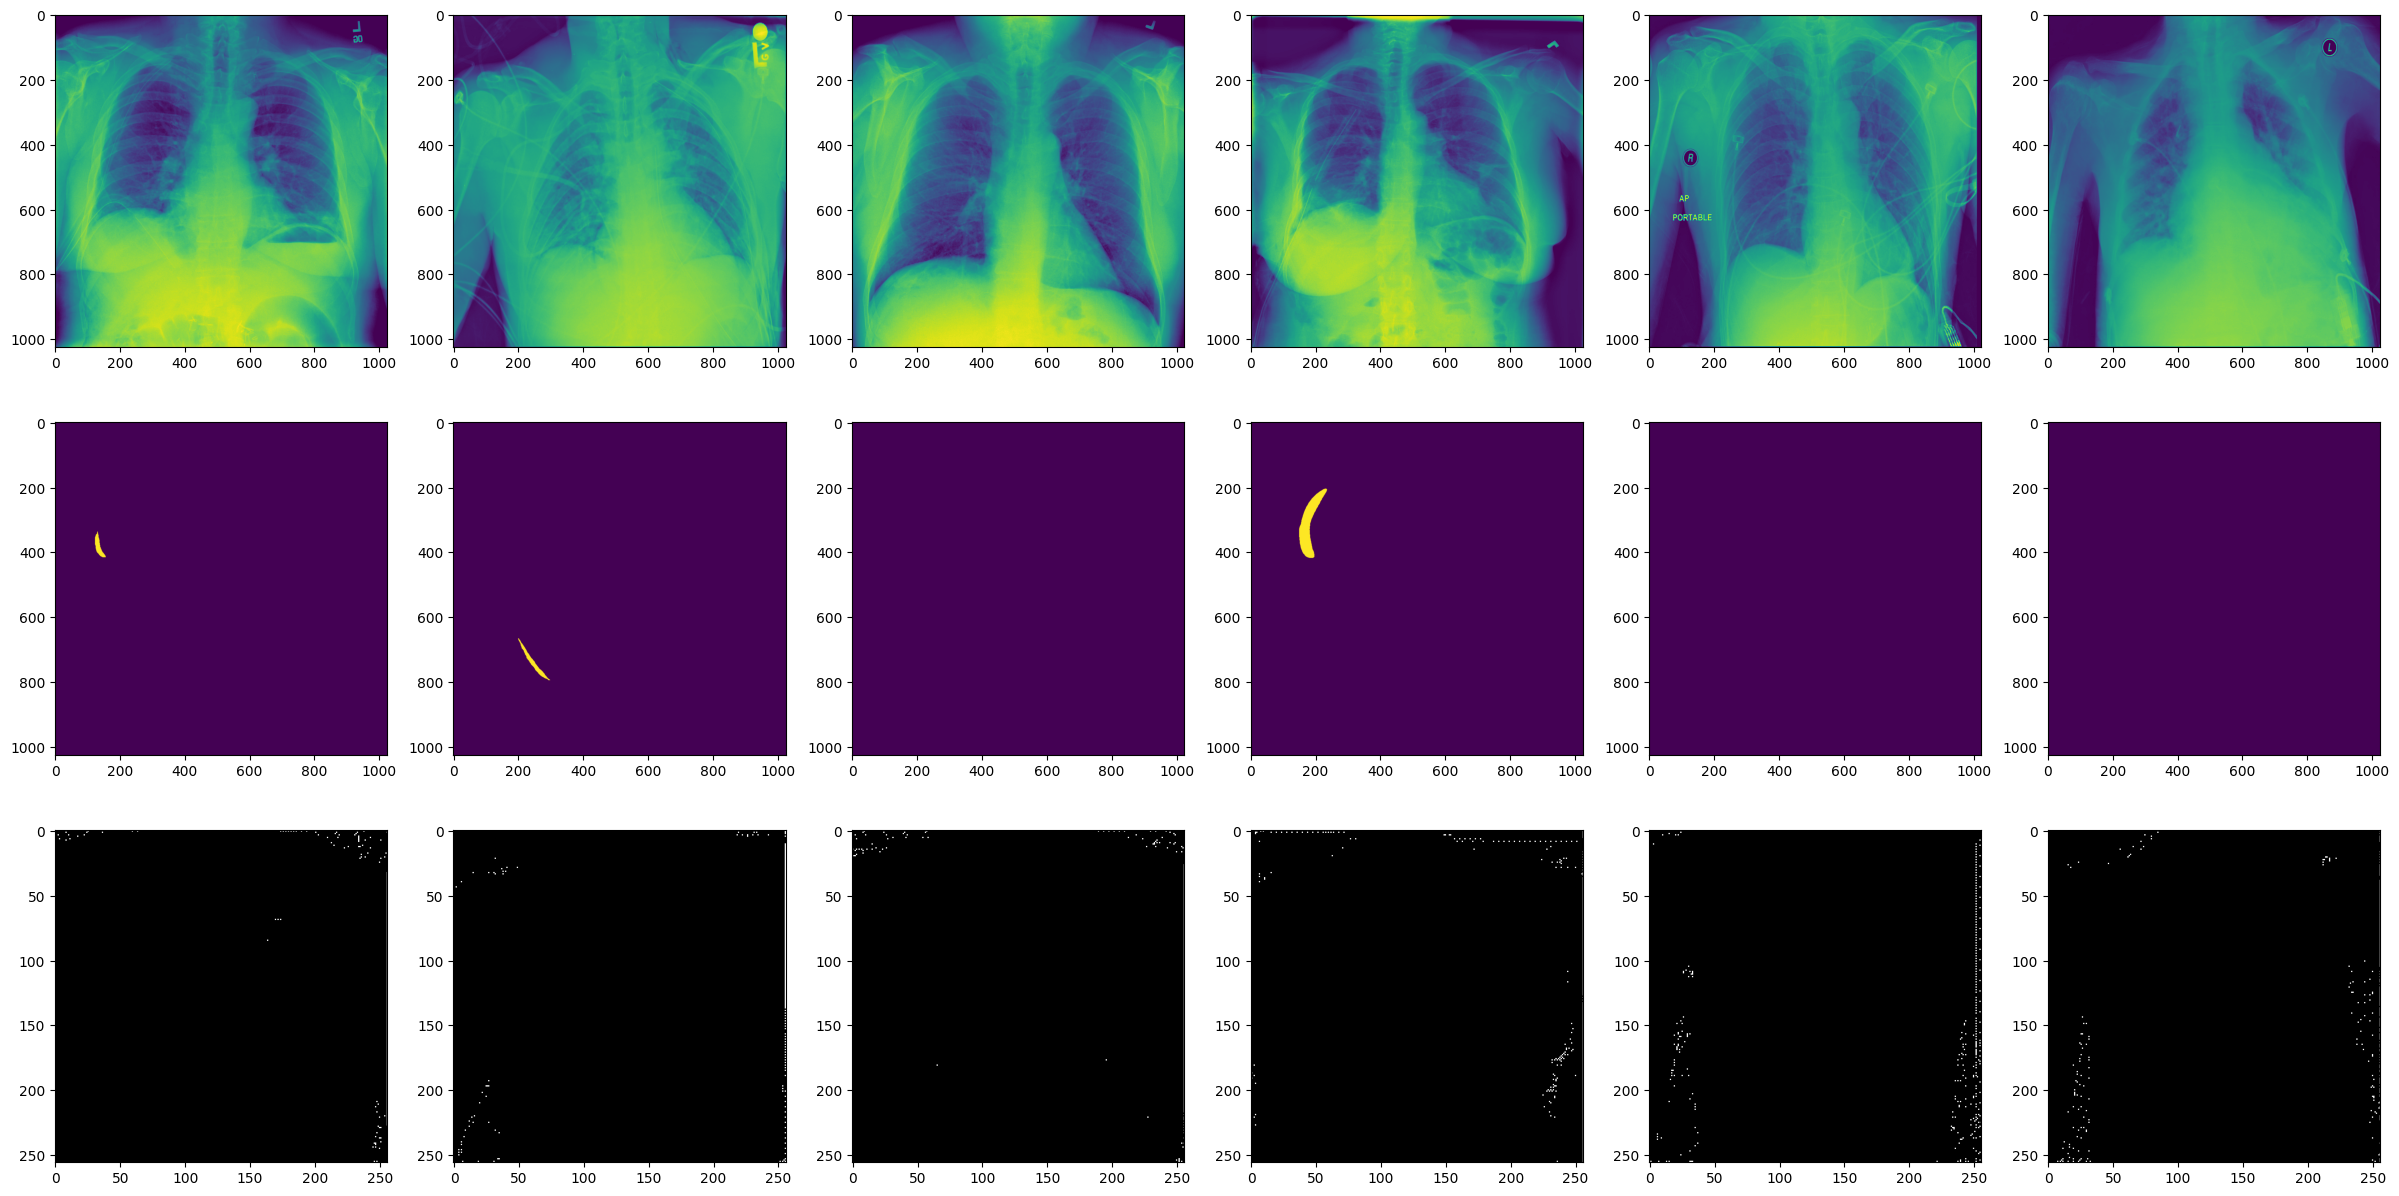

In [41]:
n=6
fig, axs = plt.subplots(3, n, figsize = (30,15))
for idx, file in enumerate(np.random.choice(os.listdir(images_for_prediction_path), n, replace=False)):
        path = os.path.join(images_for_prediction_path, file)
        dcm = pydicom.dcmread(path + "/images/" + file + ".dcm").pixel_array
        gt = plt.imread(path + "/masks/mask_" + file.split("_")[1] + ".png")
        mask = plt.imread(path + "/predicted_masks/" + file + "_res_u_net_predicted_mask.png")
        axs[0, idx].imshow(dcm)
        axs[1, idx].imshow(gt)
        axs[2, idx].imshow(mask)